In [1]:
run -i import_file.py

In [2]:
X_train = pd.read_csv('X_train.csv', encoding='cp949').drop(columns='ID')
y_train = pd.read_csv('y_train.csv', encoding='cp949').Salary
X_test = pd.read_csv('X_test.csv', encoding='cp949')
test_id = X_test.pop('ID')
X = pd.concat([X_train,X_test])
Xy_train = pd.concat([X_train,y_train],axis=1)

- 결측값 확인

['Malgun Gothic']


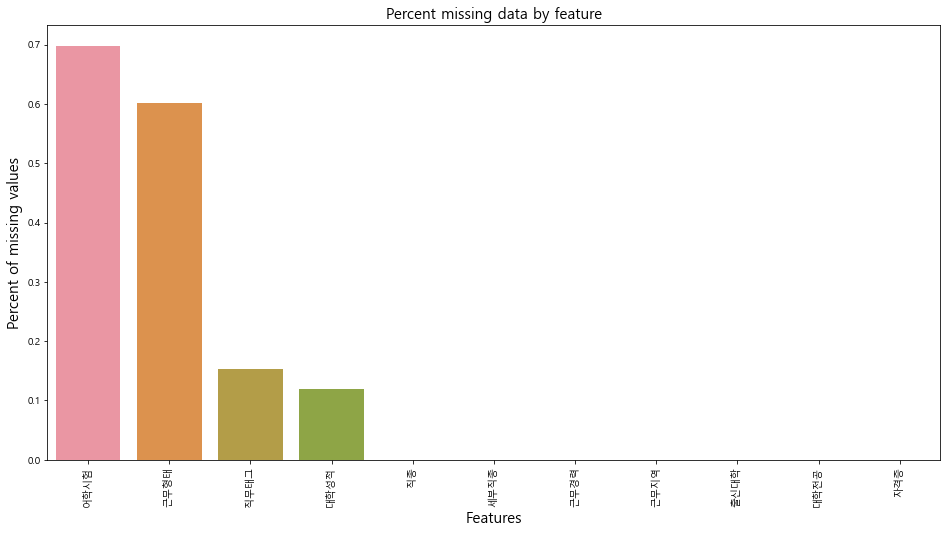

In [3]:
plt.rc('font', family='Malgun Gothic')
print(plt.rcParams['font.family'])


total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

missing_data=missing_data.head(35)
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.title('Percent missing data by feature', fontsize=15)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.show()

In [4]:
#범주, 수치형 변수 나누기
numeric_feats = X.dtypes[X.dtypes != "object"].index
categoric_feats = X.dtypes[X.dtypes == "object"].index

# Get features with missing values
na_numeric_feats = [k for k, v in X[numeric_feats].isnull().sum().to_dict().items() if v > 0]
na_categoric_feats = [k for k, v in X[categoric_feats].isnull().sum().to_dict().items() if v > 0]

- 대학시험 전처리

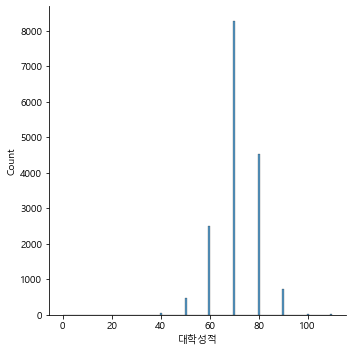

In [5]:
#수치형변수 결측값 처리 & 분포도
imp = SimpleImputer(strategy="median")
X_train[na_numeric_feats] = imp.fit_transform(X_train[na_numeric_feats])
X_test[na_numeric_feats] = imp.transform(X_test[na_numeric_feats])
sns.displot(X_train['대학성적'])

- 어학시험 전처리

In [6]:
def language(X):
    X['어학시험'] = X['어학시험'].fillna('없음')
    X['어학시험'] = np.where(X['어학시험'] == ' ','없음',X['어학시험'])
    X['어학시험'] = np.where(X['어학시험'].str.startswith('기타'), '기타' ,X['어학시험'])
    X['어학시험'] = np.where(X['어학시험'].str.startswith('TOEFL'), 'TOEFL' ,X['어학시험'])
    X['어학시험'] = np.where(X['어학시험'].str.startswith('G-TELP'), 'G-TELP' ,X['어학시험'])
    X['어학시험'] = np.where(X['어학시험'].str.endswith('LF') , 'DELF' ,X['어학시험'])
    X['어학시험'] = np.where(X['어학시험'].str.endswith('HSK') , 'HSK' ,X['어학시험'])
    X['어학시험'] = np.where(X['어학시험'].str.startswith('J'), 'JLPT' ,X['어학시험'])

In [7]:
language(X_train)
language(X_test)

- 근무형태 and 근무형태 해외(Feature Generation)

In [8]:
def workform(X):
    geo = X['근무형태'].str.split(',').apply(lambda x: pd.Series(x)).iloc[:,:4]
    for i in range(geo.shape[1]):
        geo[i]= np.where(geo[i]==' ','없음',geo[i])
        geo[i] = geo[i].fillna('없음')
    geo.columns = ['근무형태1','근무형태2','근무형태3','근무형태4']
    return geo
X_train = pd.concat([X_train,workform(X_train)],axis=1)
X_test = pd.concat([X_test,workform(X_test)],axis=1)

In [9]:
def workshape(X):
    null_list = X[X['근무경력']=='0개월'].index
    X['근무형태'][null_list] = X['근무형태'][null_list].fillna('경력없음')
    X['근무형태'] = X['근무형태'].fillna('missing')
    X['근무형태'] = np.where(X['근무형태'].str.startswith('정규직'), '정규직' ,X['근무형태'])
    X['근무형태'] = np.where(X['근무형태'].str.startswith('계약직'), '계약직' ,X['근무형태'])
    X['근무형태'] = np.where(X['근무형태'].str.startswith('인턴'), '인턴' ,X['근무형태'])

In [10]:
workshape(X_train)
workshape(X_test)

- 근무지역 전처리

In [11]:
#근무지역 중복 제거 및 분할
def worksite(X):
    geo = X['근무지역'].str.split(',').apply(lambda x: pd.Series(x))
    geo[0]
    geo_lst = []
    for i in range(geo.shape[0]):
        geo_lst.append(sorted(list(set(geo.loc[i,:]))))
    geo_mat = pd.DataFrame(geo_lst)
    geo_mat = geo_mat.fillna('')
    temp = (geo_mat[0] + ' ' + geo_mat[1] + ' ' +  geo_mat[2]).str.strip()
    site_df = temp.str.split(' ').apply(lambda x: pd.Series(x)).fillna('없음')
    site_df.columns = ['근무1지역', '근무2지역', '근무3지역']
    return site_df

worksite(X_train)
worksite(X_test)

,근무1지역,근무2지역,근무3지역
0,서울,중국,캐나다
1,서울,없음,없음
2,경남,경북,부산
3,경기,서울,없음
4,경기,서울,없음
...,...,...,...
11043,부산,서울,없음
11044,경기,서울,인천
11045,경기,서울,없음
11046,부산,없음,없음


In [12]:
#한번만 실행
site_df = worksite(X_train)
X_train = pd.concat([X_train,site_df],axis=1)
#X_train.drop(columns='근무지역',inplace=True)

site_df = worksite(X_test)
X_test = pd.concat([X_test,site_df],axis=1)
#X_test.drop(columns='근무지역',inplace=True)

- 대학전공 and 대학전공 계열(Feature Generation)

In [13]:
major_sum = pd.read_csv('major_sum.csv',encoding='cp949').fillna('미포함')
def major(X):
    X['대학전공'] = X['대학전공'].str.replace('(',',')
    X['대학전공'] = X['대학전공'].str.replace('·',',')
    X['대학전공'] = X['대학전공'].str.replace('/',',')
    X['대학전공'] = X['대학전공'].str.replace('.',',')
    X['대학전공'] = X['대학전공'].str.replace(')','')
    X['대학전공'] = X['대학전공'].str.replace('ㆍ',',')
    X['대학전공'] = X['대학전공'].str.replace('<',',')
    X['대학전공'] = X['대학전공'].str.replace('>','')
    X['대학전공'] = X['대학전공'].str.replace('&',',')
    X['대학전공'] = X['대학전공'].str.replace(':',',')
    X['대학전공'] = X['대학전공'].str.replace('*',',')
    X['대학전공'] = X['대학전공'].str.replace(' ','')
    major = X['대학전공'].str.split(',').apply(lambda x: pd.Series(x)).iloc[:,:3].fillna('없음')
    for j in major.columns:
        for i in major_sum.columns:
            example_test= major_sum[i]
            test = '|'.join(example_test) 
            major.loc[major[j].str.contains(test),j] = str(i) + '학과'
    major.columns = ['전공1','전공2','전공3']
    return major
X_train = pd.concat([X_train,major(X_train)],axis=1)
X_test = pd.concat([X_test,major(X_test)],axis=1)

In [14]:
def major_cat(X):
    major_cat = pd.read_csv('major_cat.csv',encoding='cp949')
    for i in range(X.shape[0]):
        if X.loc[i,'대학전공'] in set(major_cat['문과'].values):
            X.loc[i,'대학전공_계열'] = '인문계열'
        elif X.loc[i,'대학전공'] in set(major_cat['이과'].values):
            X.loc[i,'대학전공_계열'] = '자연,공학계열'
        elif X.loc[i,'대학전공'] in set(major_cat['예체능'].values):
            X.loc[i,'대학전공_계열'] = '예체능계열'
        else:
            X.loc[i,'대학전공_계열'] = '기타'
major_cat(X_train)
major_cat(X_test)

- 출신대학 등급

In [15]:
def univ_level(X):
    univ = pd.read_csv('univ_level1.csv',encoding='cp949')
    for i in range(X.shape[0]):
        if X.loc[i,'출신대학'] in set(univ['상위권'].values):
            X.loc[i,'출신대학_등급'] = '상위권'
        elif X.loc[i,'출신대학'] in set(univ['중위권'].values):
            X.loc[i,'출신대학_등급'] = '중위권'
        elif X.loc[i,'출신대학'] in set(univ['하위권'].values):
            X.loc[i,'출신대학_등급'] = '하위권'
        else:
            X.loc[i,'출신대학_등급'] = '기타'
univ_level(X_train)
univ_level(X_test)

- 근무경력 전처리

In [16]:
X_train['년수'] = np.where(X_train['근무경력'].str.contains('년'),X_train['근무경력'].str[:3].str.replace('년',''),0).astype('int')
X_test['년수'] = np.where(X_test['근무경력'].str.contains('년'),X_test['근무경력'].str[:3].str.replace('년',''),0).astype('int')
X_train['개월 수'] = X_train['근무경력'].str[-4:].replace('개월').str.strip().str.replace('개월','').astype('int')
X_test['개월 수'] = X_test['근무경력'].str[-4:].replace('개월').str.strip().str.replace('개월','').astype('int')
X_train['연차'] = X_train['년수'] + X_train['개월 수']/12
X_test['연차'] = X_test['년수'] + X_test['개월 수']/12
X_train.drop(columns=['년수','개월 수'],inplace=True)
X_test.drop(columns=['년수','개월 수'],inplace=True)

- 근무지역 국내외

In [17]:
out = ['필리핀', '인도네시아', '대만', '프랑스', '방글라데시', 
       '해외', '미국', '러시아', '말레이시아', '인도',
       '일본', '싱가포르', '중국', '홍콩', '캐나다']
def worksite_abroad(X):
    for i in range(X.shape[0]):
        if X.loc[i,'근무1지역'] in out:
            X.loc[i,'근무지역_해외'] = '해외'
        elif X.loc[i,'근무2지역'] in out:
            X.loc[i,'근무지역_해외'] = '해외'
        elif X.loc[i,'근무3지역'] in out:
            X.loc[i,'근무지역_해외'] = '해외'
        else:
            X.loc[i,'근무지역_해외'] = '국내'
worksite_abroad(X_train)
worksite_abroad(X_test)

- 출신대학 수도권_비수도권

In [18]:
def univ(X):    
    for i in range(X.shape[0]):
        if X.loc[i,'출신대학'] in metro:
            X.loc[i,'출신대학_지역'] = '수도권'
        else:
            X.loc[i,'출신대학_지역'] = '비수도권'
univ_list = list(pd.concat([X_train['출신대학'],y_train],axis=1).groupby('출신대학').mean().sort_values(by='Salary').index)
metro = ['서울과학기술대학교','연세대학교','성균관대학교','중앙대학교',
 '이화여자대학교','경기대학교','인천대학교','세종대학교','수원대학교',
 '한국산업기술대학교','한성대학교','서울여자대학교','성신여자대학교','동덕여자대학교',
 '성공회대학교','용인대학교','협성대학교']
side = []
for i in univ_list:
    if i not in metro:
        side.append(i)
univ(X_train)
univ(X_test)

- 스펙점수 방정식
 출신대학_등급(3) 근무지역 해외(2) 어학시험유무(2) 
- 각 feature별로 점수 책정
ex) 상위권(3) + 근무지역_해외(2) + 어학시험_무(1) = 7

In [19]:
print(('상위권 해외:' ,pd.concat([X_train,y_train],axis=1)[(pd.concat([X_train,y_train],axis=1)['출신대학_등급']=='상위권') & (pd.concat([X_train,y_train],axis=1)['근무지역_해외']=='해외')]['Salary'].mean()))
print(('중위권 해외:' ,pd.concat([X_train,y_train],axis=1)[(pd.concat([X_train,y_train],axis=1)['출신대학_등급']=='중위권') & (pd.concat([X_train,y_train],axis=1)['근무지역_해외']=='해외')]['Salary'].mean()))
print(('하위권 해외:' ,pd.concat([X_train,y_train],axis=1)[(pd.concat([X_train,y_train],axis=1)['출신대학_등급']=='하위권') & (pd.concat([X_train,y_train],axis=1)['근무지역_해외']=='해외')]['Salary'].mean()))
print('출신대학의 등급별로 해외 근무지에서의 연봉이 다르다')

print(('상위권 국내:' ,pd.concat([X_train,y_train],axis=1)[(pd.concat([X_train,y_train],axis=1)['출신대학_등급']=='상위권') & (pd.concat([X_train,y_train],axis=1)['근무지역_해외']=='국내')]['Salary'].mean()))
print(('중위권 국내:' ,pd.concat([X_train,y_train],axis=1)[(pd.concat([X_train,y_train],axis=1)['출신대학_등급']=='중위권') & (pd.concat([X_train,y_train],axis=1)['근무지역_해외']=='국내')]['Salary'].mean()))
print(('하위권 국내:' ,pd.concat([X_train,y_train],axis=1)[(pd.concat([X_train,y_train],axis=1)['출신대학_등급']=='하위권') & (pd.concat([X_train,y_train],axis=1)['근무지역_해외']=='국내')]['Salary'].mean()))
print('출신대학의 등급별로 국내 근무지에서의 연봉이 다르다')

('상위권 해외:', 3666.687422166874)
('중위권 해외:', 2998.1435643564355)
('하위권 해외:', 2928.799489144317)
출신대학의 등급별로 해외 근무지에서의 연봉이 다르다
('상위권 국내:', 3356.3065533315053)
('중위권 국내:', 2561.537335285505)
('하위권 국내:', 2552.8465017291833)
출신대학의 등급별로 국내 근무지에서의 연봉이 다르다


In [20]:
def equation1(X):
    rank = []
    workabroad = []
    languagetest = []
    for i in range(X.shape[0]):
        if X.loc[i,'출신대학_등급'] == '상위권':
            rank.append(3)
        elif X.loc[i,'출신대학_등급'] == '중위권':
            rank.append(2)
        else:
            rank.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'근무지역_해외'] == '해외':
            workabroad.append(2)
        else:
            workabroad.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'어학시험'] != '없음':
            languagetest.append(2)
        else:
            languagetest.append(1)
    equation_score = np.array(rank) + np.array(workabroad) + np.array(languagetest)
    X['스펙점수'] = equation_score
    
equation1(X_train)
equation1(X_test)

In [21]:
X_train['스펙점수'] = X_train['스펙점수'] ** 2
X_test['스펙점수'] = X_test['스펙점수'] ** 2

- 세부직종 RANK생성

In [22]:
def specific_rank(X):
    specific_rank = pd.read_csv('specific_rank.csv',encoding='cp949')
    for i in range(X.shape[0]):
        if X.loc[i,'세부직종'] in set(specific_rank['상위25%'].values):
            X.loc[i,'세부직종_등급'] = 'A'
        elif X.loc[i,'세부직종'] in set(specific_rank['상위50%'].values):
            X.loc[i,'세부직종_등급'] = 'B'
        elif X.loc[i,'세부직종'] in set(specific_rank['상위75%'].values):
            X.loc[i,'세부직종_등급'] = 'C'
        else:
            X.loc[i,'세부직종_등급'] = 'D'
specific_rank(X_train)
specific_rank(X_test)

- 직무태그 개수

In [23]:
X_train['직무태그'] = X_train['직무태그'].fillna('없음')
X_test['직무태그'] = X_test['직무태그'].fillna('없음')

In [24]:
def tag_count(X):
    X['직무태그'] = X['직무태그'].str.strip()

    a = []
    for i in X.직무태그.str.split(','):
        b = len(i)
        a.append(b)
    X['직무태그_갯수'] = a
tag_count(X_train)
tag_count(X_test)

- 숙련도

In [25]:
def blacksmith(X):
    a = []

    for i in X['연차']:
        if i==0:
            b = '경력없음'
        elif i <=2:
            b = '하'
        elif i <=4:
            b = '중'
        elif i <=6:
            b = '중상'
        else:
            b = '상'
        a.append(b)
    X['숙련도'] = a
blacksmith(X_train)
blacksmith(X_test)
    # data.drop(columns='근무경력', inplace=True)

- 수치형변수 이상치 제어

In [26]:
X_train['연차'] = np.clip(X_train['연차'],0,60)
X_test['연차'] = np.clip(X_test['연차'],0,60)

- NEW 스펙점수

In [27]:
def equation2(X):
    rank = []
    workabroad = []
    languagetest = []
    workform = []
    blacksmith = []
    for i in range(X.shape[0]):
        if X.loc[i,'출신대학_등급'] == '상위권':
            rank.append(3)
        elif X.loc[i,'출신대학_등급'] == '중위권':
            rank.append(2)
        else:
            rank.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'근무지역_해외'] == '해외':
            workabroad.append(2)
        else:
            workabroad.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'어학시험'] != '없음':
            languagetest.append(2)
        else:
            languagetest.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'근무형태'] == '정규직':
            workform.append(2)
        else:
            workform.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'숙련도'] == '상':
            blacksmith.append(4)
        elif  X.loc[i,'숙련도'] == '중상':
            blacksmith.append(3)
        elif  X.loc[i,'숙련도'] == '중':
            blacksmith.append(2)            
        elif  X.loc[i,'숙련도'] == '하':
            blacksmith.append(1)
        else:
            blacksmith.append(0)
    equation_score = np.array(rank) + np.array(workabroad) + np.array(languagetest) + np.array(workform) + np.array(blacksmith)
    X['NEW스펙점수'] = equation_score
   
equation2(X_train)
equation2(X_test)

In [28]:
X_train['NEW스펙점수'] = X_train['NEW스펙점수'] ** 2
X_test['NEW스펙점수'] = X_test['NEW스펙점수'] ** 2

- 세부직종 기타합

In [29]:
#세부직종 99%(sample<10)이상 기타
def specific(X):
    specific = (X['세부직종'].value_counts() < 10).reset_index()
    temp = np.array(specific[specific['세부직종'] == True]['index'])
    for i in range(X.shape[0]):
        if X.loc[i,'세부직종'] in temp:
            X.loc[i,'세부직종_기타'] = '기타'
        else:
            X.loc[i,'세부직종_기타'] = X.loc[i,'세부직종']
specific(X_train)
specific(X_test)

- 전공1 추합 및 기타생성

In [30]:
major_add = pd.read_csv('major_sum_add.csv',encoding='cp949').fillna('미포함')

In [31]:
def major_sum_add(X):
    for i in major_add.columns:
        example_test= major_add[i]
        test = '|'.join(example_test) 
        X.loc[X['전공1'].str.contains(test),'전공1'] = str(i) + '학과'
major_sum_add(X_train)
major_sum_add(X_test)

In [32]:
#주요 Feature 전공1(sample=1) -> 기타
def major1(X):
    major1 = (X['전공1'].value_counts() < 2).reset_index()
    temp = np.array(major1[major1['전공1'] == True]['index'])
    for i in range(X.shape[0]):
        if X.loc[i,'전공1'] in temp:
            X.loc[i,'전공1'] = '기타'
        else:
            X.loc[i,'전공1'] = X.loc[i,'전공1']
major1(X_train)
major1(X_test)

- 연차 방정식

In [33]:
def equation3(X):
    year = []
    rank=[]
    workform = []

    for i in range(X.shape[0]):
        if X.loc[i,'연차'] == 0:
            year.append(0)
        elif X.loc[i,'연차'] <= 1:
            year.append(1)
        elif X.loc[i,'연차'] <= 3:
            year.append(2)
        elif X.loc[i,'연차'] <= 5:
            year.append(3)
        elif X.loc[i,'연차'] <= 8:
            year.append(4)
        elif X.loc[i,'연차'] <= 10:
            year.append(5)
        elif X.loc[i,'연차'] <= 13:
            year.append(6)
        else:
            year.append(7)
    for i in range(X.shape[0]):
        if X.loc[i,'출신대학_등급'] == '상위권':
            rank.append(3)
        elif X.loc[i,'출신대학_등급'] == '중위권':
            rank.append(2)
        else:
            rank.append(1)
    for i in range(X.shape[0]):
        if X.loc[i,'근무형태'] == '정규직':
            workform.append(2)
        else:
            workform.append(1)

    equation_score = np.array(rank) + np.array(year)  + np.array(workform) 
    X['연차방정식'] = equation_score
   
equation3(X_train)
equation3(X_test)

- 직무태그 통합

In [34]:
tag_train = pd.read_csv('X_train.csv',encoding='cp949')['직무태그']
tag_test = pd.read_csv('X_test.csv', encoding='cp949')['직무태그']
X_train['직무태그'] = tag_train
X_test['직무태그'] = tag_test
#ver1
X_train['직무태그'] = X_train['직무태그'].fillna('NO DATA')
X_test['직무태그'] = X_test['직무태그'].fillna('NO DATA')

In [35]:
tag_summary = pd.read_csv('tag_sum.csv',encoding='cp949')
tag_summary = tag_summary.fillna('없음')
def tag_sum2(X):
    col = []
    tag = X['직무태그'].str.split(',').apply(lambda x: pd.Series(x)).iloc[:,:20].fillna('결측')
    for j in tag.columns:
        tag[j] = tag[j].str.lower()
        tag[j] = tag[j].str.strip()
        try:
            for i in tag_summary.columns:
                example_test= tag_summary[i]
                test = '|'.join(example_test) 
                tag.loc[tag[j].str.contains(test),j] = str(i)
        except:
            continue
    for i in tag.columns:
        col.append('직무태그'+str(i))
        
    tag.columns = col
    return tag

X_train = pd.concat([X_train,tag_sum2(X_train)],axis=1)
X_test = pd.concat([X_test,tag_sum2(X_test)],axis=1)

- 여대 여부

In [36]:
def woman(X):
    g_d = []
    for i in X['출신대학']:
        if '여자' in i:
            g_d.append('yes')
        else :
            g_d.append('no')
    X['여대'] = g_d
woman(X_train)
woman(X_test)

- 직무태그 PCA

In [37]:
data = pd.concat([X_train,X_test])
sentences = data['직무태그']
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(sentences)
vocab = vectorizer.get_feature_names()
new = pd.DataFrame(features.toarray(), columns = vocab)
X_train_New = new[:16570]
X_test_New = new[16570:]
rnd_pca = PCA(n_components=30,svd_solver='randomized',random_state=2)
X_train_reduced2 = rnd_pca.fit_transform(X_train_New)
X_test_reduced2 = rnd_pca.transform(X_test_New)

In [38]:
train = pd.DataFrame(X_train_reduced2)
test = pd.DataFrame(X_test_reduced2)
X_train = pd.concat([X_train, train],axis=1)
X_test = pd.concat([X_test, test],axis=1)

In [39]:
categorical_features = list(X_train.select_dtypes(include="object").columns)
numeric_features = list(X_test.select_dtypes(exclude="object").columns)
scores = []  # CV 결과 저장
oof_pred = np.zeros(X_test.shape[0])  # OOF 저장

kfold = KFold(n_splits=5, shuffle=True, random_state=0) # K-Folds cross-validator # 셔플 안하면 원래 데이터 순서대로.

for train_index, valid_index in kfold.split(X_train, y_train): 
    # 학습/검증 데이터 분할
    train_x, valid_x = X_train.iloc[train_index], X_train.iloc[valid_index]
    train_y, valid_y = y_train.iloc[train_index], y_train.iloc[valid_index]

    # 범주형피처 직접 처리와 Early stopping을 사용하여 CatBoost 모델링
    model = CatBoostRegressor(cat_features=categorical_features, verbose=False ,random_state=0)
    model.fit(train_x, train_y, 
              eval_set=[(valid_x,valid_y)],
              early_stopping_rounds=100, # 얘는 과대적합을 줄이기 위해서
             )

    # CV 스코어 계산 및 저장
    rmse = np.sqrt(mean_squared_error(valid_y, model.predict(valid_x)))
    scores.append(rmse)

    # OOF 예측값 저장
    oof_pred += model.predict(X_test) / kfold.get_n_splits()
    
scores = np.array(scores)
print("CV scores: ", scores)
print("CV mean = %.2f" % scores.mean(), "with std = %.2f" % scores.std())

CV scores:  [825.13371699 809.79962418 830.6056068  785.35797013 796.72702899]
CV mean = 809.52 with std = 16.95


In [43]:
#submission 화일 생성·
CATBOOST_VERSION ='modelB'
filename = f'catboost_{CATBOOST_VERSION}_{scores.mean():.2f}.csv'
pd.DataFrame({'ID':test_id, 'Salary':oof_pred}).to_csv(filename, index=False)

## STACKING

- catboost 생성

In [45]:
def get_stacking_data(model, X_train, y_train, X_test, n_folds=5):     
  kfold = KFold(n_splits = n_folds,shuffle=True, random_state = 42)

  train_fold_predict = np.zeros((X_train.shape[0],1))


  test_predict = np.zeros((X_test.shape[0], n_folds))
  print('model : ',model.__class__.__name__)
  
  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_valid = X_train.iloc[valid_index]

    # 학습
    model.fit(X_train_,y_train_)

    train_fold_predict[valid_index,:] = model.predict(X_valid).reshape(-1,1)

    test_predict[:,cnt] = model.predict(X_test)

  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  
  return train_fold_predict, test_predict_mean

In [47]:
model = CatBoostRegressor(cat_features=categorical_features, verbose=False ,random_state=0)
cat_train , cat_test = get_stacking_data(model, X_train, y_train, X_test, n_folds=5)

model :  CatBoostRegressor


In [48]:
cat_data = pd.concat([pd.DataFrame(cat_train), pd.DataFrame(cat_test)],axis=1)
cat_data.columns = ['modelB_train','modelB_test']
cat_data.to_csv('modelB_cat_data.csv')

- LGBM

In [49]:
def get_stacking_data(model, X_train, y_train, X_test, n_folds=5):     
  kfold = KFold(n_splits = n_folds,shuffle=True, random_state = 267)
  

  train_fold_predict = np.zeros((X_train.shape[0],1))

  test_predict = np.zeros((X_test.shape[0], n_folds))
  print('model : ',model.__class__.__name__)
  
  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_valid = X_train.iloc[valid_index]


    model.fit(X_train_,y_train_)

    train_fold_predict[valid_index,:] = model.predict(X_valid).reshape(-1,1)

    test_predict[:,cnt] = model.predict(X_test)
  

  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  
  return train_fold_predict, test_predict_mean

In [50]:
X_train.columns = list(map(str,X_train.columns))
X_test.columns = list(map(str,X_test.columns))
X_train.columns = X_train.columns+'temp'
X_test.columns = X_test.columns+'temp'
categorical_features = list(X_train.select_dtypes(include="object").columns)
numeric_features = list(X_test.select_dtypes(exclude="object").columns)
X_train = X_train[numeric_features+categorical_features]
X_test = X_test[numeric_features+categorical_features]

In [54]:
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
#         ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})),
#         ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore', dtype=int)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer),
        ("selector", SelectPercentile(percentile=100)),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LGBMRegressor(random_state=0)),
    ]
)

set_config(display="diagram")  # To view the text pipeline, change to display='text'.
model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['대학성적temp',
                                                                    '연차temp',
                                                                    '스펙점수temp',
                                                                    '직무태그_갯수temp',
                                                                    'NEW스펙점수temp',
                                                                    '연차방정식temp',
                                                                    '0temp',
                                                                    '1temp',
                                                                    '2temp',
                                                                    '3temp',
                                                                    '4temp',
                                                                    '5temp',
                                                                    '6temp',
                                                                    '7temp',
                                                                    '8temp',
                                                                    '9temp',
                                                                    '10temp',
                                                                    '11temp',
                                                                    '12temp',
                                                                    '13temp',
                                                                    '14temp',
                                                                    '15temp',
                                                                    '...
                                                                    '자격증temp',
                                                                    '근무형태1temp',
                                                                    '근무형태2temp',
                                                                    '근무형태3temp',
                                                                    '근무형태4temp',
                                                                    '근무1지역temp',
                                                                    '근무2지역temp',
                                                                    '근무3지역temp',
                                                                    '전공1temp',
                                                                    '전공2temp',
                                                                    '전공3temp',
                                                                    '대학전공_계열temp',
                                                                    '출신대학_등급temp',
                                                                    '근무지역_해외temp',
                                                                    '출신대학_지역temp',
                                                                    '세부직종_등급temp',
                                                                    '숙련도temp',
                                                                    '세부직종_기타temp',
                                                                    '직무태그0temp',
                                                                    '직무태그1temp',
                                                                    '직무태그2temp', ...])])),
                                 ('selector',
                                  SelectPercentile(percentile=100))])),
                ('class

In [52]:
lgbm_train, lgbm_test = get_stacking_data(model, X_train, y_train, X_test)

model :  Pipeline


In [53]:
lgbm_data = pd.concat([pd.DataFrame(lgbm_train), pd.DataFrame(lgbm_test)],axis=1)
lgbm_data.columns = ['modelB_lgbm_train','modelB_lgbm_test']
lgbm_data.to_csv('modelB_lgbm_data.csv')

In [55]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

sscv = ShuffleSplit(test_size=0.3334, n_splits=5,random_state=0)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=sscv)

print("Default LM CV scores: ", np.sqrt(-1*scores))
print("Default LM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

Default LM CV scores:  [833.69748286 813.58626314 838.26293185 835.89553031 817.16696566]
Default LM CV mean = 827.79 with std = 130.08
